# Single Graphlet Analysis

In this notebook, I perform two actions:
1. I separate orbits extracted from each cell lines and put them together.
in such way, orbit 0 of the cells will be in a file, orbits 1 will be i.
in such way, separate file and so forth until the 72nd orbit.

2. I then run mine.jar on the files to extract the pairwise MIC values. As a result of this
step, I will have pairwise MIC comparison between all cell lines for all orbitals of a 
certain chromosome.

By repeating steps 1 and 2 for all 23 chromosomes, I will have pairwise MIC values for all
orbitals of all cell lines. I woulb eventually be able to have a data array of shape
``` A(23 * 73) ```, where the rows correspond to the chromosomes and columns correspond
to orbits.


In [2]:
import numpy as np
import cv2
from utility import *
import matplotlib.pyplot as plt
from iced import normalization
from iced import filter
from scipy.stats import t
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
chr2 = chr1 = 22

The following R-script reads graphlet files corresponding the a chromosome which
are located under ```data/*.edges```. It then writes the resulting orbits into
```data/*.graphlets```.

In [38]:
os.system('Rscript rscript.r %s'%chr1)

0

In [3]:
chr1 = 3
chr2 = chr1
print "chromosome 1: %s, chromosome 2: %s"%(chr1, chr2)
#print observed_mit_original.shape

mit = readMat("../data/extracted_all_contact_MIT/chr_%02d_%02d_500kb.mat"%\
              (chr1, chr2), "\t")
call4 = readMat("../data/extracted_all_contact_call4/chr_%02d_%02d_500kb.mat"%\
                (chr1, chr2), "\t")
rl = readMat("../data/extracted_all_contact_RL/chr_%02d_%02d_500kb.mat"%(chr1, chr2), "\t")

chromosome 1: 3, chromosome 2: 3


In [4]:
all = readMat("../data/extracted_all_contact_ALL/chr_%02d_%02d_500kb.mat"%(chr1, chr2), "\t")

In [5]:
n0, m0 = np.shape(mit)
n1, m1 = np.shape(call4)
n2, m2 = np.shape(rl)
n3, m3 = np.shape(all)

n = np.min([n0, m0, n1, m1, n2, m2, n3, m3])
mit = mit[:n, :n]
call4 = call4[:n, :n]
rl = rl[:n, :n]
all = all[:n, :n]

In [6]:
mit = pearson(scn(gaussian_normalize(mit)))
call4 = pearson(scn(gaussian_normalize(call4)))
rl = pearson(scn(gaussian_normalize(rl)))
print call4.shape

(391, 391)


In [8]:
all = pearson(scn(gaussian_normalize(rl)))

In [9]:
min, max, mean_mit, std_mit = print_statistics(mit, "mit")
min, max, mean_rl, std_rl = print_statistics(rl, "rl")
min, max, mean_call4, std_call4 = print_statistics(call4, "call4")
min, max, mean_all, std_all = print_statistics(all, "all")

#-----------------------------------------------------------------------#
Stats for mit: 
max: 1.000000 | min: -0.057665 | median: -0.007164 | mean: 0.000825 | std: 0.054108
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for rl: 
max: 1.000000 | min: -0.053589 | median: -0.002150 | mean: 0.000433 | std: 0.050681
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for call4: 
max: 1.000000 | min: -0.032048 | median: -0.002314 | mean: 0.000182 | std: 0.050644
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for all: 
max: 1.000000 | min: -0.081476 | median: -0.002772 | mean: 0.000354 | std: 0.050826
#-----------------------------------------------------------------------#


Number of columnts: 4


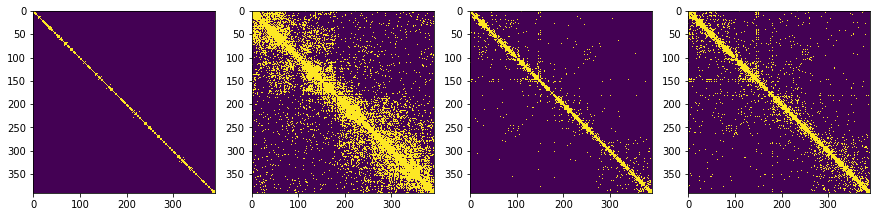

In [10]:
pylab.rcParams['figure.figsize'] = (15, 9)
images = [
        (call4) > 0
        , (mit) > 0
        , (rl) > 0
        , (all) > 0
        ]
showImages(images, 1)

Number of columnts: 4


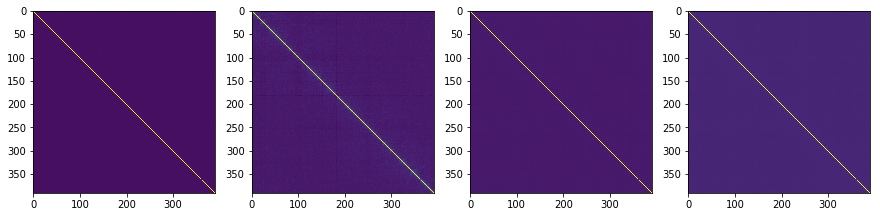

In [11]:
images = [
        np.log(call4+1)
        , np.log(mit+1)
        , np.log(rl+1)
        , np.log(all+1)
        ]
showImages(images, 1)

In [12]:
convertBinaryMatToOrcaReadable(call4 > 0, "data/chr%02d_chr%02d_call4.edges"%(chr1, chr1))
convertBinaryMatToOrcaReadable(mit > 0, "data/chr%02d_chr%02d_mit.edges"%(chr1, chr1))
convertBinaryMatToOrcaReadable(rl > 0, "data/chr%02d_chr%02d_rl.edges"%(chr1, chr1))
convertBinaryMatToOrcaReadable(all > 0, "data/chr%02d_chr%02d_all.edges"%(chr1, chr1))

I can now read the orbital files and put them into a $N \times O$ matrix where $N$ denotes
number of loci in the chromosome and $O$ denotes the number or obitals extracted, which 
can be either 14 or 73 (depending on whether ```count4()``` or ```count5()``` are called
in the R-script above.

In [13]:
graphlets_mit = readMat("data/chr%02d_chr%02d_mit.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
graphlets_all = readMat("data/chr%02d_chr%02d_all.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
graphlets_rl = readMat("data/chr%02d_chr%02d_rl.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
graphlets_call4 = readMat("data/chr%02d_chr%02d_call4.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
print(graphlets_mit.shape)
print(graphlets_all.shape)
print(graphlets_rl.shape)
print(graphlets_call4.shape)

(391, 73)
(391, 73)
(391, 73)
(391, 73)


In [15]:
mit_all_corr = \
    graphlet_correlational_distance(graphlets_mit, graphlets_all)

In [16]:
mit_mit_corr = \
    graphlet_correlational_distance(graphlets_mit, graphlets_mit)

In [17]:
mit_call4_corr = \
    graphlet_correlational_distance(graphlets_mit, graphlets_call4)

In [18]:
mit_rl_corr = \
    graphlet_correlational_distance(graphlets_mit, graphlets_rl)


Number of columnts: 2


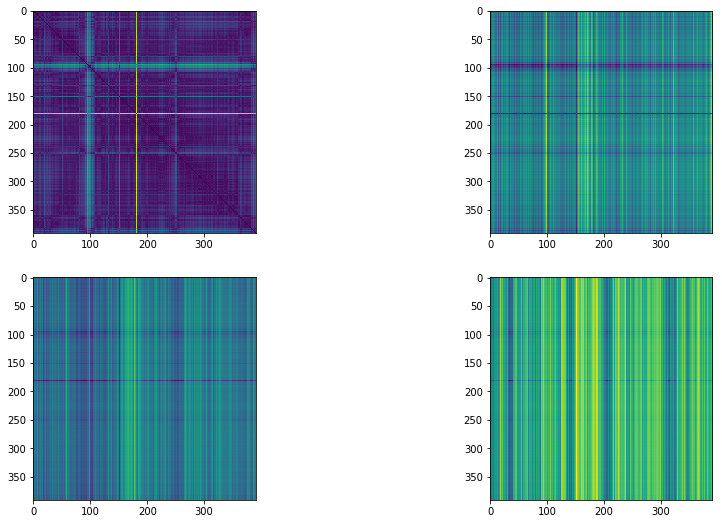

In [19]:
images = [ mit_mit_corr
          , mit_all_corr
         , mit_rl_corr
         , mit_call4_corr]
showImages(images, 2)

In [20]:
print_statistics(mit_mit_corr)
print_statistics(mit_all_corr)
print_statistics(mit_rl_corr)
print_statistics(mit_call4_corr)

#-----------------------------------------------------------------------#
Stats for : 
max: 1.464597 | min: 0.000000 | median: 0.141609 | mean: 0.183276 | std: 0.153546
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for : 
max: 2.207065 | min: 0.658505 | median: 1.365477 | mean: 1.373682 | std: 0.179704
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for : 
max: 4.118116 | min: 1.068633 | median: 2.239338 | mean: 2.288463 | std: 0.298913
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for : 
max: 4.469617 | min: 3.400858 | median: 4.081259 | mean: 4.075095 | std: 0.148007
#-----------------------------------------------------------------------#


(4.469616723064088, 3.4008584941455666, 4.07509450538009, 0.14800683174023455)

In [21]:
print_statistics(np.diagonal(mit_mit_corr))
print_statistics(np.diagonal(mit_all_corr))
print_statistics(np.diagonal(mit_rl_corr))
print_statistics(np.diagonal(mit_call4_corr))
n = mit_mit_corr.shape[0]
#t1 = (t_test(np.diagonal(mit_mit_corr)))
t2 = (t_test(np.diagonal(mit_all_corr)))
t3 = (t_test(np.diagonal(mit_rl_corr)))
t4 = (t_test(np.diagonal(mit_call4_corr)))
print(n)
#print(t1)
print(t2)
print(t3)
print(t4)

print("p-value for mit-all: %10.3e"%(1 - t.cdf(t2, n-1)))
print("p-value for mit-rl: %10.3e"%(1 - t.cdf(t3, n-1)))
print("p-value for mit-call4: %10.3e"%(1 - t.cdf(t4, n-1)))



#-----------------------------------------------------------------------#
Stats for : 
max: 0.000000 | min: 0.000000 | median: 0.000000 | mean: 0.000000 | std: 0.000000
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for : 
max: 2.161133 | min: 0.719218 | median: 1.363225 | mean: 1.374714 | std: 0.174143
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for : 
max: 4.117633 | min: 1.410812 | median: 2.243016 | mean: 2.286506 | std: 0.312053
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for : 
max: 4.469550 | min: 3.662796 | median: 4.077379 | mean: 4.075067 | std: 0.147716
#-----------------------------------------------------------------------#
391
19.591851163624845
19.56

In [36]:
graphlets = {'mit' : graphlets_mit
            , 'all' : graphlets_all
            , 'rl' : graphlets_rl
            , 'call4' : graphlets_call4}
pair_orbits(graphlets, chr1)

shape of graphlet for chromosome 1 of cell rl:                 454 by 73
shape of graphlet for chromosome 1 of cell call4:                 454 by 73
shape of graphlet for chromosome 1 of cell all:                 454 by 73
shape of graphlet for chromosome 1 of cell mit:                 454 by 73
('number of matrices:', 4)
data/chr01_orbit00.paired.csv
data/chr01_orbit01.paired.csv
data/chr01_orbit02.paired.csv
data/chr01_orbit03.paired.csv
data/chr01_orbit04.paired.csv
data/chr01_orbit05.paired.csv
data/chr01_orbit06.paired.csv
data/chr01_orbit07.paired.csv
data/chr01_orbit08.paired.csv
data/chr01_orbit09.paired.csv
data/chr01_orbit10.paired.csv
data/chr01_orbit11.paired.csv
data/chr01_orbit12.paired.csv
data/chr01_orbit13.paired.csv
data/chr01_orbit14.paired.csv
data/chr01_orbit15.paired.csv
data/chr01_orbit16.paired.csv
data/chr01_orbit17.paired.csv
data/chr01_orbit18.paired.csv
data/chr01_orbit19.paired.csv
data/chr01_orbit20.paired.csv
data/chr01_orbit21.paired.csv
data/chr01_orbit